# Creation of Matched Datasets - 14 March 2022 Case

In order to evaluate the SAIL field campaign snowfall retrievals, a dataset containing the radar column above each of our sites of interest, matched with in-situ ground observations is desired. 

## Current List of Supported In-Situ Ground Observations
- Pluvio Weighing Bucket Precipitation Gauge [WBPLUVIO2] (DOI: 10.5439/1338194)
- Surface Meteorological Instrumentation [MET] (DOI: 10.5439/1786358)

## Planned In-Situ Ground Observations (More Suggestions Welcome!)
- Laser Disdrometer [LD] (DOI: 10.5439/1779709)
- Balloon-borne sounding system [SONDEWNPN] (DOI: 10.5439/1595321)
- Radar Wind Profiler [RWP] 

## Imports

In [1]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
from matplotlib.dates import DateFormatter
import pandas as pd


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define Functions 

In [2]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        # Make sure we are interpolating from the radar's location above sea level
        # NOTE: interpolating throughout Troposphere to match sonde to in the future
        da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(radar.altitude['data'][0], 100000, 100))
        #da = pyart.util.columnsect.get_field_location(radar, lat, lon)
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
        da["time"] = [dt]
        column_list.append(da)
    # Concatenate the extracted radar columns for this scan across all sites    
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites
    # Add attributes for Time, Latitude, Longitude, and Sites
    ds.time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                    + " of each Individual Radar Volume Scan before"
                                    + " Concatenation"),
                         units='seconds',
                         description=('Time in Seconds that Cooresponds to the Minimum'
                                      + ' Height Gate'))
    ds.site.attrs.update(long_name="SAIL/SPLASH In-Situ Ground Observation Sites Identifers")
    ds.latitude.attrs.update(long_name='Latitude of SAIL Ground Observation Site',
                             units='Degrees North')
    ds.longitude.attrs.update(long_name='Longitude of SAIL Ground Observation Site',
                             units='Degrees East')
    return ds

In [3]:
def match_datasets(column, ground, site):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations
    
    Parameters
    ----------
    column : Xarray DataSet
             Xarray DataSet containing the extracted radar column above multiple locations.
             Dimensions should include Time, Height, Site
             
    ground : str 
             String containing the path of the ground instrumentation file that is desired
             to be included within the extracted radar column dataset
             
    site : str
           Location of the ground instrument. Should be included within the filename. 
             
    Returns
    -------
    ds : Xarray DataSet
         Xarray Dataset containing the time-synced in-situ ground observations with
         the inputed radar column 
    """
    # Read in the file
    grd_ds = xr.open_dataset(ground)

    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    matched = grd_ds.resample(time='5Min', closed='right').sum(keep_attrs=True).interp(time=column.time, method='linear') 
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
    
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
        
    # Update the individual Pluvio Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(platform_id=matched.platform_id)
        matched[var].attrs.update(data_level=matched.data_level)
        matched[var].attrs.update(location_description=matched.location_description)
        matched[var].attrs.update(datastream=matched.datastream)
        matched[var].attrs.update(doi=matched.doi)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
    
    # Tranpose the xarray DataSet to match the order of dimensions across all variables
    column = column.transpose("time", "height", "site")
    
    return column 

## Define the Location of the SAIL Sites. 

In [4]:
# Define the splash locations [lon,lat]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]
M1 = [-106.987, 38.9565]

sites = ["M1", "kettle_ponds", "brush_creek", "avery_point", "pumphouse_site", "roaring_judy"]

# Zip these together!
lons, lats = list(zip(M1,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      roaring_judy))

## List the Available CSU X-Band Corrected Precipitation Radar Moments in Antenna Coordinates Version 2 (CMAC2.0) Files

#### In contrast to the Merged CSU X-Band files previously used, the CSU X-Band CMAC2.0 files have been corrected for beam blockage and clutter, as well as, undergone additional processing. 

#### Z-S Relationships previously explored are applied during the CMAC2.0 processing of the CSU X-Band data. Therefore, all we need to do now is extract the radar columns and combine with ground instruments. 

In [5]:
#file_list = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacM1.c1/ppi/202203/gucxprecipradarcmacM1.c1.20220314*"))
file_list = sorted(glob.glob("/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/*"))
file_list[:10]

['/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-000759.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-001839.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-002359.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-002919.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-003959.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc',
 

In [6]:
%%time
ds_list = []
for file in file_list:
    ds_list.append(subset_points(file, lats, lons, sites))

CPU times: user 17min 3s, sys: 2min 49s, total: 19min 53s
Wall time: 21min 31s


## Combine all Extracted Radar Columns to Form Daily Timeseries

In [16]:
ds = xr.concat(ds_list, dim='time')

In [17]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 969, site: 6, time: 118)
Coordinates:
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * site                                      (site) <U14 'M1' ... 'roaring_j...
Data variables: (12/33)
    DBZ                                       (time, site, height) float64 na...
    VEL                                       (time, site, height) float64 na...
    WIDTH                                     (time, site, height) float64 na...
    ZDR                                       (time, site, height) float64 na...
    PHIDP                                     (time, site, height) float64 na...
    RHOHV                                     (time, site, height) float64 na...
    ...                                        ...
    snow_rate_ws2012                          (time, site, height) float64 na...
    snow_rate_ws88dhp                         (time, site, height) float64 na...
    snow_rate_ws88diw                         (time, site, height) float64 na...
    base_time                                 (time, site) datetime64[ns] 197...
    latitude                                  (time, site) float64 38.96 ... ...
    longitude                                 (time, site) float64 -107.0 ......
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

## Add in the Pluvio Weighing Bucket Data

In [18]:
# Define the file path
npluvio = "/Users/celsloaner/ARM/Observations/WPLUVIO2/gucwbpluvio2M1.a1.20220314.000000.nc"
# Define the site location based on the filename
pluv_site = npluvio.split('gucwbpluvio2')[-1].split('.')[0]

In [19]:
ds = match_datasets(ds, npluvio, pluv_site)

## Add the Surface Meteorological Station (MET) to the Matched Dataset

In [20]:
# Define the file path
nmet = "/Users/celsloaner/ARM/inProgress/gucmetM1.b1.20220314.000000.cdf"
# Read in the file
#met_ds = xr.open_dataset(nmet)
# Define the site location based on the filename
met_site = nmet.split('gucmet')[-1].split('.')[0]

In [21]:
ds = match_datasets(ds, nmet, met_site)

In [22]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 969, site: 6, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
Data variables: (12/96)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    tbrg_precip_total_corr                    (time, site) float64 0.0 ... nan
    qc_tbrg_precip_total_corr                 (time, site) float64 0.0 ... nan
    logger_volt                               (time, site) float64 58.45 ... nan
    qc_logger_volt                            (time, site) float64 0.0 ... nan
    logger_temp                               (time, site) float64 50.34 ... nan
    qc_logger_temp                            (time, site) float64 0.0 ... nan
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

## Plot the Matched Dataset for the M1 Site

Text(0.5, 0.98, 'SAIL CSU X-Band - Ground Observations Matched Dataset - 14 March 2022')

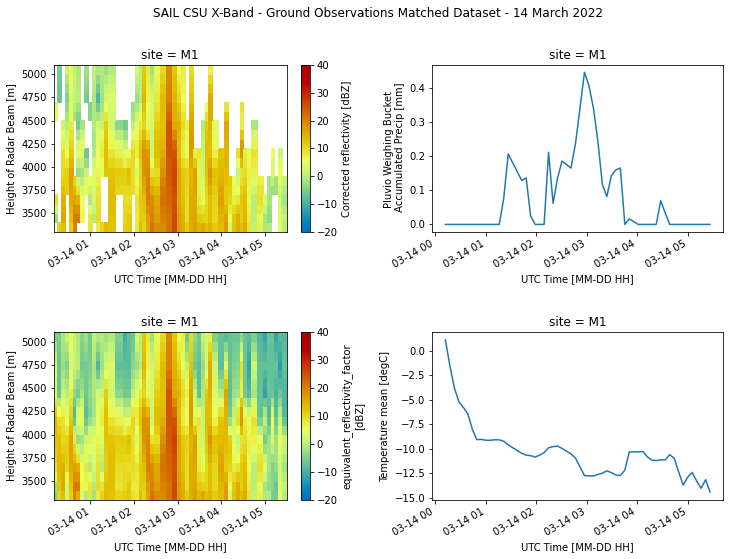

In [26]:
# Define figure and axes 
fig, axarr = plt.subplots(2, 2, figsize=[12,8])
plt.subplots_adjust(hspace=0.6, wspace=0.3)

# Plot the Corrected Reflectivity factor for the M1 site. 
# Event took place between 0Z-5Z on 14 March 2022. Slice for those times. 
ds.corrected_reflectivity.sel(site='M1').sel(time=slice('2022-03-14T00', 
                                                        '2022-03-14T06')).plot(x='time',
                                                                               cmap='pyart_HomeyerRainbow',
                                                                               vmin=-20,
                                                                               vmax=40,
                                                                               ax=axarr[0, 0])
# Limit the height of the beam as storm was shallow
axarr[0, 0].set_ylim([3300, 5100])
# Rename X-axis
axarr[0, 0].set_xlabel('UTC Time [MM-DD HH]')

# Plot the Pluvio Weighing Bucket accumulation
ds.accum_rtnrt.sel(site='M1').sel(time=slice('2022-03-14T00',
                                             '2022-03-14T06')).plot(x='time', ax=axarr[0, 1])
# Rename the labels. 
axarr[0, 1].set_xlabel('UTC Time [MM-DD HH]')
axarr[0, 1].set_ylabel('Pluvio Weighing Bucket \n Accumulated Precip [mm]')

# Plot the Un-Corrected Reflecitivty factor for the M1 Site. 
ds.DBZ.sel(site='M1').sel(time=slice('2022-03-14T00',
                                     '2022-03-14T06')).plot(x='time',
                                                            cmap='pyart_HomeyerRainbow',
                                                            vmin=-20,
                                                            vmax=40,
                                                            ax=axarr[1, 0])
# Limit the height of the beam as storm was shallow
axarr[1, 0].set_ylim([3300, 5100])
# Rename X-axis
axarr[1, 0].set_xlabel('UTC Time [MM-DD HH]')

# Plot the MET's Surface Temperature
ds.temp_mean.sel(site='M1').sel(time=slice('2022-03-14T00',
                                           '2022-03-14T06')).plot(x='time', ax=axarr[1, 1])
axarr[1, 1].set_xlabel('UTC Time [MM-DD HH]')

# Define a plot title. 
plt.suptitle('SAIL CSU X-Band - Ground Observations Matched Dataset - 14 March 2022')